In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm

import time

In [3]:
# Keras & Tensorflow
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

In [4]:
benign_train = np.load('/content/drive/MyDrive/CSE499/numpy/benign_train.npy')
malign_train = np.load('/content/drive/MyDrive/CSE499/numpy/malign_train.npy')
benign_test = np.load('/content/drive/MyDrive/CSE499/numpy/benign_test.npy')
malign_test = np.load('/content/drive/MyDrive/CSE499/numpy/malign_test.npy')
print('Done Loaded :)')

Done Loaded :)


In [5]:
#Shape of our dataset
print(f'Benign Train:',benign_train.shape)
print(f'Malignant Train',malign_train.shape)
print(f'Benign Test:',benign_test.shape)
print(f'Malignant Test',malign_test.shape)

Benign Train: (3500, 224, 224, 3)
Malignant Train (3496, 224, 224, 3)
Benign Test: (1500, 224, 224, 3)
Malignant Test (1500, 224, 224, 3)


In [6]:
benign_train_label = np.zeros(len(benign_train),dtype=float)
malign_train_label = np.ones(len(malign_train),dtype=float)
benign_test_label = np.zeros(len(benign_test),dtype=float)
malign_test_label = np.ones(len(malign_test),dtype=float) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [7]:
print(f'X train shape:',X_train.shape)
print(f'X test shape:',X_test.shape)
print(f'Y train shape:',Y_train.shape)
print(f'Y test shape:',Y_test.shape)

X train shape: (6996, 224, 224, 3)
X test shape: (3000, 224, 224, 3)
Y train shape: (6996, 2)
Y test shape: (3000, 2)


In [8]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)

In [9]:
print(f'x train shape:',x_train.shape)
print(f'x val shape:',x_val.shape)
print(f'y train shape:',y_train.shape)
print(f'y val shape:',y_val.shape)

x train shape: (5596, 224, 224, 3)
x val shape: (1400, 224, 224, 3)
y train shape: (5596, 2)
y val shape: (1400, 2)


In [10]:
from tensorflow.keras.applications import EfficientNetB0

def eff_model(backbone , lr = 1e-4):
  effmodel = Sequential()
  effmodel.add(backbone)
  effmodel.add(layers.GlobalAveragePooling2D())
  effmodel.add(layers.Dropout(0.5))
  effmodel.add(layers.BatchNormalization())
  effmodel.add(layers.Dense(2 , activation='softmax'))
  
  effmodel.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
  return effmodel


EfficientNet = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
#call the model 
effmodel = eff_model(EfficientNet , lr = 1e-4)
effmodel.build((None, 224, 224, 3))
effmodel.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                         

In [11]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
epochs = 20
batch_size = 64
teacher_his = effmodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/20
88/88 [==============================] - 119s 1s/step - loss: 0.2794 - accuracy: 0.8964 - val_loss: 0.3621 - val_accuracy: 0.7829
Epoch 2/20
88/88 [==============================] - 94s 1s/step - loss: 0.1327 - accuracy: 0.9505 - val_loss: 0.2096 - val_accuracy: 0.9036
Epoch 3/20
88/88 [==============================] - 94s 1s/step - loss: 0.0840 - accuracy: 0.9668 - val_loss: 0.1561 - val_accuracy: 0.9350
Epoch 4/20
88/88 [==============================] - 95s 1s/step - loss: 0.0593 - accuracy: 0.9771 - val_loss: 0.1276 - val_accuracy: 0.9507
Epoch 5/20
88/88 [==============================] - 95s 1s/step - loss: 0.0419 - accuracy: 0.9855 - val_loss: 0.1213 - val_accuracy: 0.9593
Epoch 6/20
88/88 [==============================] - 94s 1s/step - loss: 0.0334 - accuracy: 0.9886 - val_loss: 0.1231 - val_accuracy: 0.9600
Epoch 7/20
88/88 [==============================] - 94s 1s/step - loss: 0.0259 - accuracy: 0.9916 - val_loss: 0.1320 - val_accuracy: 0.9607
Epoch 8/20
88/88 [=

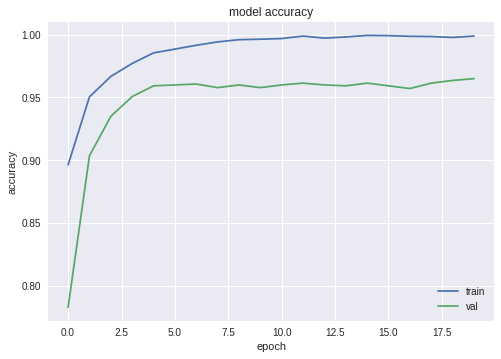

In [12]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

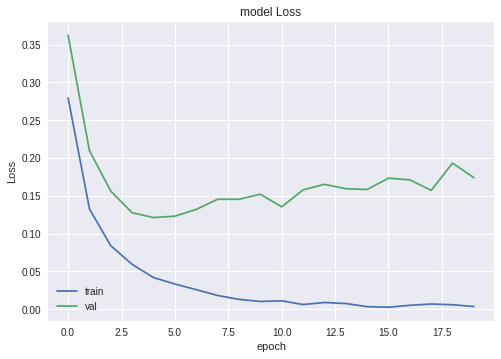

In [13]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [14]:
Y_val_pred = effmodel.predict(x_val)
print(f'The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The Teacher model Accuracy on the Validation Set: 0.965


In [15]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [17]:
#Now let's check my predcited values from X_test dataset	
# And calculate the y_pred with time
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = effmodel.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[9.9999416e-01 5.7927532e-06]
 [1.0000000e+00 1.0926226e-08]
 [8.8282454e-10 1.0000000e+00]
 ...
 [1.0000000e+00 3.8120131e-08]
 [9.9999988e-01 1.7801651e-07]
 [1.0000000e+00 1.5832557e-09]]

Time:  10.757064066999646 sec


In [18]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy: 0.9986666666666667


In [19]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1500
           1       1.00      1.00      1.00      1500

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

